In [1]:
import cv2
from PIL import Image
import os
import re
import time
import numpy as np
from sklearn import svm
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt 
from mahotas.features import zernike_moments
from mahotas.features import haralick
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
def load_from_dir(dir, dir_cat, data):
    for file in os.listdir(dir):
        if not file.endswith(".jpg"):
            continue

        filename = os.path.join(dir, file)
        zoom = int(re.search(r'\d+x', file).group()[:-1])

        data['filename'].append(filename)
        data['category'].append(dir_cat)
        data['zoom'].append(zoom)

In [3]:
def get_hu(X):
    features = []
    for x in X:
        img_hu = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        hu_features = cv2.HuMoments(cv2.moments(img_hu)).flatten()
        features.append(hu_features)

    return features


def get_zernike(X):
    features = []
    radius = 10
    for x in X:
        x = x[:, :, 0]
        #img_zernike = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        img_zernike = x
        zernike_features = zernike_moments(img_zernike, radius).flatten()
        features.append(zernike_features)

    return features    


def get_hu_and_zernike(X):
    features = []
    radius = 10
    for x in X:
        img_hu = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)
        hu_features = cv2.HuMoments(cv2.moments(img_hu)).flatten()

        img_zernike = x[:, :, 0]
        zernike_features = zernike_moments(img_zernike, radius).flatten()

        img_features = img_features = np.hstack([hu_features, zernike_features])
        features.append(img_features)

    return features

In [4]:
DATA_DIR = 'data/new_data/cut_structures/'

data = {
    'filename': [],
    'category': [],
    'zoom': [],
}

#load_from_dir(DATA_DIR + '0', '0', data) # kreski
load_from_dir(DATA_DIR + 'I', 'I', data) # kreski
load_from_dir(DATA_DIR + 'II', 'II', data) # kleksy
load_from_dir(DATA_DIR + 'III', 'III', data) # robaczki
load_from_dir(DATA_DIR + 'IV', 'IV', data) # mroczki
load_from_dir(DATA_DIR + 'V', 'V', data) # plamy
load_from_dir(DATA_DIR + 'VI', 'VI', data) # kółka

df = pd.DataFrame(data)

In [5]:
df

filename category  zoom
0     data/new_data/cut_structures/I\Kopia 0_origina...        I   500
1     data/new_data/cut_structures/I\Kopia 0_origina...        I   500
2     data/new_data/cut_structures/I\Kopia 0_origina...        I   500
3     data/new_data/cut_structures/I\Kopia 0_origina...        I   500
4     data/new_data/cut_structures/I\Kopia 0_origina...        I   500
...                                                 ...      ...   ...
1546  data/new_data/cut_structures/VI\Kopia 53_1_3_5...       VI   500
1547  data/new_data/cut_structures/VI\Kopia 53_1_3_5...       VI   500
1548  data/new_data/cut_structures/VI\Kopia 55_1_2_5...       VI   500
1549  data/new_data/cut_structures/VI\Kopia 55_1_2_5...       VI   500
1550  data/new_data/cut_structures/VI\Kopia 55_1_2_5...       VI   500

[1551 rows x 3 columns]

In [6]:
X = []
y = []
for _, data in df.iterrows():
    img = cv2.imread(data.filename)
    X.append(img)
    y.append(data.category)
X = np.array(X)
y = np.array(y)

In [7]:
X.shape

(1551, 251, 335, 3)

In [8]:
SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

## ----------------- Hu moments -----------------

In [9]:
X_train_features_hu = get_hu(X_train)
X_test_features_hu = get_hu(X_test)

#X_train_features[0].shape

#### SVM

In [10]:
clf_svm_hu = SVC(kernel='rbf', random_state=9, max_iter=1000)
clf_svm_hu.fit(X_train_features_hu, y_train)

clf_svm_hu.score(X_test_features_hu, y_test)

0.2829581993569132

#### Decision Tree

In [11]:
clf_tree_hu = DecisionTreeClassifier()
clf_tree_hu.fit(X_train_features_hu, y_train)

clf_tree_hu.score(X_test_features_hu, y_test)

0.3054662379421222

#### Random Forest

In [12]:
clf_forest_hu = RandomForestClassifier()
clf_forest_hu.fit(X_train_features_hu, y_train)

clf_forest_hu.score(X_test_features_hu, y_test)

0.3183279742765273

#### Logistic Regression

In [15]:
clf_logreg_hu = LogisticRegression()
clf_logreg_hu.fit(X_train_features_hu, y_train)

clf_logreg_hu.score(X_test_features_hu, y_test)

0.2829581993569132

#### Multi-layer Perceptron 

In [16]:
clf_mlp_hu = MLPClassifier()
clf_mlp_hu.fit(X_train_features_hu, y_train)

clf_mlp_hu.score(X_test_features_hu, y_test)

0.2829581993569132

#### AdaBoost

In [17]:
clf_aboost_hu = AdaBoostClassifier()
clf_aboost_hu.fit(X_train_features_hu, y_train)

clf_aboost_hu.score(X_test_features_hu, y_test)

0.3086816720257235

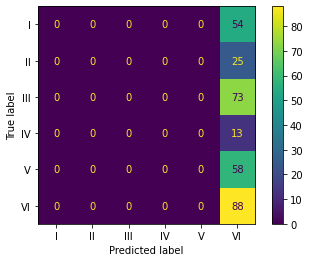

In [10]:
# svm confusion matrix:
plot_confusion_matrix(clf_svm_hu, X_test_features_hu, y_test)  
plt.show()

## ----------------- Zernike moments -----------------

In [18]:
X_train_features_zernike = get_zernike(X_train)
X_test_features_zernike = get_zernike(X_test)

#X_train_features_zernike[0].shape

#### SVM

In [19]:
clf_svm_zernike = SVC(kernel='rbf', random_state=9, max_iter=1000)
clf_svm_zernike.fit(X_train_features_zernike, y_train)

clf_svm_zernike.score(X_test_features_zernike, y_test)

0.6334405144694534

#### Decision Tree

In [20]:
clf_tree_zernike = DecisionTreeClassifier()
clf_tree_zernike.fit(X_train_features_zernike, y_train)

clf_tree_zernike.score(X_test_features_zernike, y_test)

0.5176848874598071

#### Random Forest

In [21]:
clf_forest_zernike = RandomForestClassifier()
clf_forest_zernike.fit(X_train_features_zernike, y_train)

clf_forest_zernike.score(X_test_features_zernike, y_test)

0.617363344051447

#### Logistic Regression

In [22]:
clf_logreg_zernike = LogisticRegression()
clf_logreg_zernike.fit(X_train_features_zernike, y_train)

clf_logreg_zernike.score(X_test_features_zernike, y_test)

0.5916398713826366

#### Multi-layer Perceptron

In [23]:
clf_mlp_zernike = MLPClassifier()
clf_mlp_zernike.fit(X_train_features_zernike, y_train)

clf_mlp_zernike.score(X_test_features_zernike, y_test)

D:\Programy\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6141479099678456

#### AdaBoost

In [24]:
clf_aboost_zernike = AdaBoostClassifier()
clf_aboost_zernike.fit(X_train_features_zernike, y_train)

clf_aboost_zernike.score(X_test_features_zernike, y_test)

0.5144694533762058

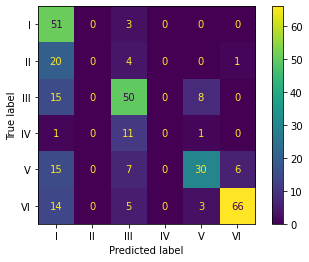

In [12]:
plot_confusion_matrix(clf_svm_zernike, X_test_features_zernike, y_test)  
plt.show()

In [13]:
#y_pred = clf_svmz.predict(X_test_features_zernike)
#confusion_matrix(y_test, y_pred)

## ----------------- Zernike and Hu moments -----------------

In [25]:
X_train_features_hu_and_zernike = get_hu_and_zernike(X_train)
X_test_features_hu_and_zernike = get_hu_and_zernike(X_test)

####  SVM

In [14]:
clf_svm_hu_and_zernike = SVC(kernel='rbf', random_state=9, max_iter=1000)
clf_svm_hu_and_zernike.fit(X_train_features_hu_and_zernike, y_train)

clf_svm_hu_and_zernike.score(X_test_features_hu_and_zernike, y_test)

0.6334405144694534

#### Decision Tree

In [26]:
clf_tree_hu_and_zernike = DecisionTreeClassifier()
clf_tree_hu_and_zernike.fit(X_train_features_hu_and_zernike, y_train)

clf_tree_hu_and_zernike.score(X_test_features_hu_and_zernike, y_test)

0.5176848874598071

#### Random Forest

In [27]:
clf_forest_hu_and_zernike = RandomForestClassifier()
clf_forest_hu_and_zernike.fit(X_train_features_hu_and_zernike, y_train)

clf_forest_hu_and_zernike.score(X_test_features_hu_and_zernike, y_test)

0.6463022508038585

#### Logistic Regression

In [28]:
clf_logreg_hu_and_zernike = LogisticRegression()
clf_logreg_hu_and_zernike.fit(X_train_features_hu_and_zernike, y_train)

clf_logreg_hu_and_zernike.score(X_test_features_hu_and_zernike, y_test)

0.5916398713826366

#### Multi-layer Perceptron

In [29]:
clf_mlp_hu_and_zernike = MLPClassifier()
clf_mlp_hu_and_zernike.fit(X_train_features_hu_and_zernike, y_train)

clf_mlp_hu_and_zernike.score(X_test_features_hu_and_zernike, y_test)

D:\Programy\anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.6109324758842444

#### AdaBoost

In [30]:
clf_aboost_hu_and_zernike = AdaBoostClassifier()
clf_aboost_hu_and_zernike.fit(X_train_features_hu_and_zernike, y_train)

clf_aboost_hu_and_zernike.score(X_test_features_hu_and_zernike, y_test)

0.5916398713826366

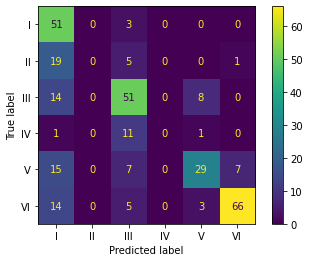

In [15]:
plot_confusion_matrix(clf_svm_hu_and_zernike, X_test_features_hu_and_zernike, y_test)  
plt.show()

## ----------------- Pixels -----------------

In [32]:
nsamples, nx, ny, nz = X_train.shape
Xd2_train = X_train.reshape((nsamples,nx*ny*nz))

nsamplest, nxt, nyt, nzt = X_test.shape
Xd2_test = X_test.reshape((nsamplest,nxt*nyt*nzt))

#### SVM

In [17]:
clf_svm = SVC(kernel='rbf', random_state=9, max_iter=1000)
clf_svm.fit(Xd2_train, y_train)

clf_svm.score(Xd2_test, y_test)

0.6430868167202572

#### Decision Tree

In [33]:
clf_tree = DecisionTreeClassifier()
clf_tree.fit(Xd2_train, y_train)

clf_tree.score(Xd2_test, y_test)

0.5112540192926045

#### Random Forest

In [34]:
clf_forest = RandomForestClassifier()
clf_forest.fit(Xd2_train, y_train)

clf_forest.score(Xd2_test, y_test)

0.6752411575562701

#### Logistic Regression

In [36]:
clf_logreg = LogisticRegression(max_iter=1000)
clf_logreg.fit(Xd2_train, y_train)

clf_logreg.score(Xd2_test, y_test)

D:\Programy\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.5337620578778135

#### Multi-layer Perceptron

In [37]:
clf_mlp = MLPClassifier()
clf_mlp.fit(Xd2_train, y_train)

clf_mlp.score(Xd2_test, y_test)

0.1864951768488746

#### AdaBoost

In [38]:
clf_aboost = AdaBoostClassifier()
clf_aboost.fit(Xd2_train, y_train)

clf_aboost.score(Xd2_test, y_test)

0.5530546623794212

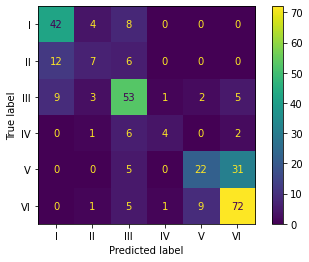

In [18]:
plot_confusion_matrix(clf_svm, Xd2_test, y_test)  
plt.show()